In [5]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from utilities import *
from VoxelGrid import *
import os


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'




In [6]:
model="materials"
dataset= "../nerf_synthetic/" + model
focal, all_c2w, all_gt = get_data(dataset, "train")

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 50.60it/s]


In [7]:
back_focal, back_c2w, back_gt = get_data(dataset, "train", True)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 80.05it/s]


In [8]:
red = 4
target_ims_carve, rays_carve = reduce_data(back_c2w, back_gt.squeeze(), back_focal, red)
print(red)
red = 4
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
print(red)
red = 4
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
print(red)

4
4
4


In [15]:
D_carve = RayDataset(target_ims_carve, rays_carve, device)
train_loader_carve = torch.utils.data.DataLoader(D_carve, batch_size=5000, shuffle=False)

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]


In [16]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=False)

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  9.06it/s]


In [170]:

class VoxelGridCarve(VoxelGrid):
    def __init__(self, size=128, bound_w=1, init_op=3):
        super().__init__(size, bound_w)
        self.colors_sum = torch.zeros_like(self.opacities)
        with torch.no_grad():
            self.opacities[:] = init_op
            self.colors[:] = 0
    def subdivide(self):
        super().subdivide()
        self.colors_sum = torch.zeros_like(self.opacities)
    def smooth_colors(self):
        with torch.no_grad():
            new_ar = 6*self.colors.clone()
            for disp1 in [1, self.size, self.size**2]:
                new_ar[:-disp1] +=self.colors[disp1:]
                new_ar[disp1:] += self.colors[:-disp1]
            self.colors[:] = new_ar/12
            
    def smooth_opacities(self):
        with torch.no_grad():
            new_ar = 6*self.opacities.clone()
            for disp1 in [1, self.size, self.size**2]:
                new_ar[:-disp1] +=self.opacities[disp1:]
                new_ar[disp1:] += self.opacities[:-disp1]
            self.opacities[:] = new_ar/12

    def carve(self, ordir_tuple, N_points, inv_depth=1.2):
        with torch.no_grad():
            ori = ordir_tuple[0][:, None,:]

            # WARNING: Assuming constant distance
            distances = 8/(N_points-1)
            scatter_points = torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth
            p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])    

            # extract valid indices
            inds_3d = torch.floor(self.descartes_to_indices(p))
            in_bounds = self.in_bounds_indices(inds_3d)
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long())
            mesh_coords[torch.logical_not(in_bounds)] = 0
            
            self.opacities[mesh_coords] = 0
            
    def color(self, ordir_tuple, pixels, N_points, inv_depth=1.2):
        with torch.no_grad():
            ori = ordir_tuple[0][:, None,:]

            # WARNING: Assuming constant distance
            distances = 8/(N_points-1)
            scatter_points = torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth
            p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])    

            # extract valid indices
            inds_3d = torch.floor(self.descartes_to_indices(p))
            in_bounds = self.in_bounds_indices(inds_3d)
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long()).long()
            mesh_coords[torch.logical_not(in_bounds)] = 0
            opacities = self.opacities[mesh_coords]*in_bounds.float() # not_in bounds: 0 opacity
            opacities = opacities*distances
            cumsum_opacities = torch.zeros_like(opacities, device=device)
            cumsum_opacities[:,1:] = torch.cumsum(opacities[:,:-1], 1)

            transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
            
            self.colors[mesh_coords,:] += transp_term[..., None]*pixels[:, None, :]
            self.colors_sum[mesh_coords] += transp_term
            
            #is_more_opaque = transp_term > self.colors_sum[mesh_coords]
            #r_pixels = pixels[:, None, :].repeat(1, mesh_coords.shape[1], 1)            
            #self.colors[mesh_coords[is_more_opaque],:] = r_pixels[is_more_opaque]
            #self.colors_sum[mesh_coords[is_more_opaque]] = transp_term[is_more_opaque]

In [8]:
VG = VoxelGridCarve(128, 1.4, 40)
N_points = 900

In [9]:
def carve(grid, loader, N_points):
    for batch_idx, (rays, pixels) in enumerate(tqdm(loader)):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        mask = (pixels==1)
        grid.carve((rays[0][mask],rays[1][mask]) , N_points)

def color(grid, loader, N_points):
    for batch_idx, (rays, pixels) in enumerate(tqdm(loader)):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        mask = (pixels==1).all(1)
        mask = torch.logical_not(mask)
        grid.color((rays[0][mask],rays[1][mask]), pixels[mask], N_points)
    with torch.no_grad():
        mask = VG.colors_sum>0
        VG.colors[mask] = VG.colors[mask]/(VG.colors_sum[mask, None])
 


100%|█████████████████████████████████████████| 800/800 [00:29<00:00, 27.29it/s]


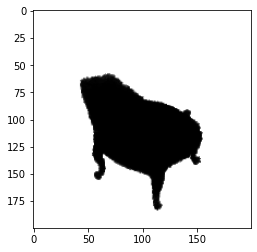

In [19]:
carve(VG, train_loader_carve, N_points)
plt.imshow(VG.render_large_image_from_rays(disp_rays[30],(N_points,1.2)))
plt.show()

100%|█████████████████████████████████████████| 800/800 [00:26<00:00, 30.65it/s]


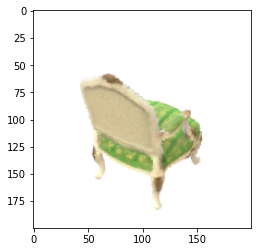

In [20]:
color(VG, train_loader, N_points)
plt.imshow(VG.render_large_image_from_rays(disp_rays[30],(N_points,1.2)))
plt.show()

In [118]:
VG2 = VoxelGridCarve(128, 1.4, 20)
with torch.no_grad():
    VG2.colors[:] = VG.colors.clone()
    VG2.opacities[:] = VG.opacities.clone()
    mask = VG.colors_sum>1
    VG2.colors[mask] = VG.colors[mask]/(VG.colors_sum[mask, None])
    VG2.clamp()
 

In [119]:
VG.clamp()

In [21]:
VG.save('chair_new.obj')

In [22]:
VG.save_pointcloud()

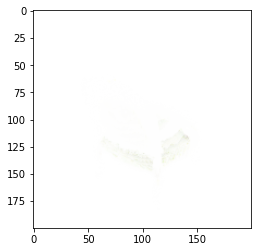

In [120]:
#VG.clamp()
plt.imshow(VG2.render_large_image_from_rays(disp_rays[30],(N_points,1.2)))
plt.show()

In [ ]:
VG.colors

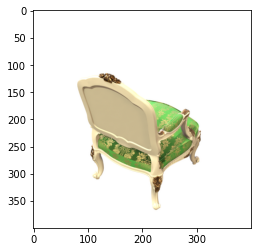

In [29]:
plt.imshow(disp_ims[30])
plt.show()

In [31]:
VG.save('chair_carve3.obj')

# Spherical

In [11]:
#VG = VoxelGridSphericalCarve(128, 1.4, 40, 9)
VG = VoxelGridCarve(128,1.4,40)

In [12]:
carve(VG, train_loader_carve, 900)

100%|█████████████████████████████████████████| 800/800 [00:19<00:00, 41.71it/s]


In [13]:
color(VG, train_loader, 900)

100%|█████████████████████████████████████████| 800/800 [00:17<00:00, 46.41it/s]


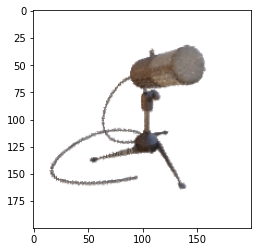

0.7913082


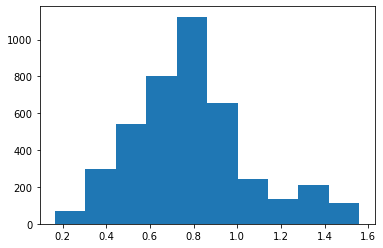

In [10]:
im2=VG.render_large_image_from_rays(disp_rays[30],(900,1.2))
plt.imshow(im2)
plt.show()

h = np.sqrt((im2**2).sum(2)).flatten()
h = h[h<np.sqrt(3)-0.1]       
print(h.mean())
        
plt.hist(h)
plt.show()

In [14]:
VG.save('materials_carve.obj')

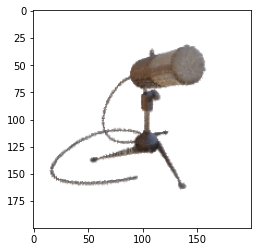

0.78913563


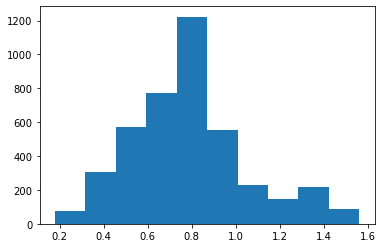

In [17]:
im2=VG.render_large_image_from_rays(disp_rays[30],(900,1.2))
plt.imshow(im2)
plt.show()

h = np.sqrt((im2**2).sum(2)).flatten()
h = h[h<np.sqrt(3)-0.1]       
print(h.mean())
        
plt.hist(h)
plt.show()

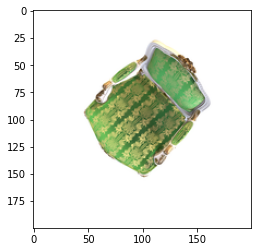

In [202]:
im = disp_ims[1] 
plt.imshow(im)
plt.show()

In [175]:
VG.save('chair_sph.obj')

In [13]:
VG2 = VoxelGridSphericalCarve(128, 1.4, 40, )
with torch.no_grad():
    VG.colors[:] *= np.sqrt(2)


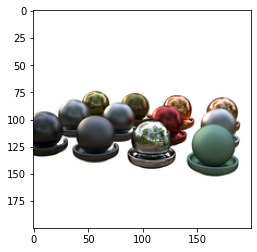

In [90]:
np.sqrt((im**2).sum(2)).flatten().shape

(10000,)

In [91]:
1.0850841/0.77

1.4092001298701298

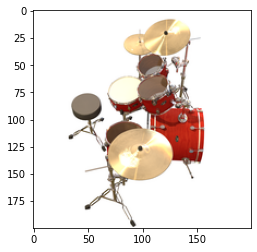

0.9858906694551106


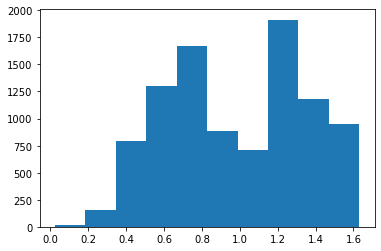

In [48]:
im = target_ims[1] 
plt.imshow(im)
plt.show()

h = np.sqrt((im**2).sum(2)).flatten()
h = h[h<np.sqrt(3)-0.1]       
print(h.mean())
        
plt.hist(h)
plt.show()

# PSNR

In [15]:
test_focal, test_c2w, test_gt = get_data("../nerf_synthetic/" + model, "test")
red = 2
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims_test[0].shape[0]

100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 62.50it/s]


In [16]:
compute_psnr(VG, disp_rays_test, disp_ims_test, 900)

100%|█████████████████████████████████████████| 200/200 [06:40<00:00,  2.00s/it]


22.255644076097823

In [8]:
cust_c2ws = create_rotation_matrices(0,30, n=60)
red_fac=2
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))

In [27]:
class VoxelGridSpherical_dev(VoxelGridSpherical):
    
    def view_harmonics(self, points):
        norm = torch.sqrt((points**2).sum(1))
        points /= norm[:, None]
        r2 = torch.sqrt((points[:, :2]**2).sum(1))
        r2 = normalize01(r2, 0, 1) #avoid numerical errors
        phi = torch.arccos(r2)
        phi[points[:,2]<0] *= -1
        phi += np.pi/2
        r2[r2==0] = 10**-10 
        diam = points[:,0]/r2
        diam = normalize01(diam, -1, 1) #avoid numerical errors
        theta = torch.arccos(diam)
        theta[points[:,1]<0] *= -1  
        theta += np.pi
        theta = theta.cpu().numpy()
        phi = phi.cpu().numpy()
        harmonics = torch.zeros((points.shape[0], self.num_harm), device=device)
        
        ind=0
        for n in range(int(np.sqrt(self.num_harm))):
            for m in range(-n,n+1):
                Y = torch.tensor(sph_harm(m,n,theta, phi), device=device)
                if m < 0:
                    Y = np.sqrt(2) * Y.imag
                elif m > 0:
                    Y = np.sqrt(2) * Y.real
                harmonics[:, ind] = torch.abs(Y)
                ind+=1
        #harmonics /= torch.sqrt((harmonics**2).sum(1))[:, None]
        harmonics = harmonics**2/((harmonics**2).sum(1))[:, None]
        return harmonics

In [28]:
VG=VoxelGridSpherical_dev(128,1.4, 9)

In [29]:
m = torch.zeros((len(cust_c2ws), VG.num_harm))
for image_ind in range(len(cust_c2ws)):
    p = torch.tensor(ordir_rays[image_ind][0][0,0], device=device)
    m[image_ind,:] = VG.view_harmonics(p[None,:])
    

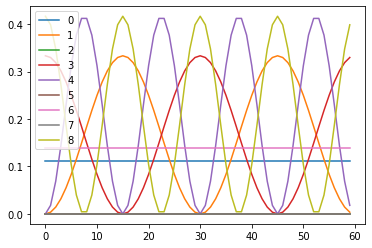

In [30]:
for i in range(0,VG.num_harm):
    plt.plot(m[:,i], label=str(i))
plt.legend()

In [21]:
f = torch.zeros(9)
f[7]=1

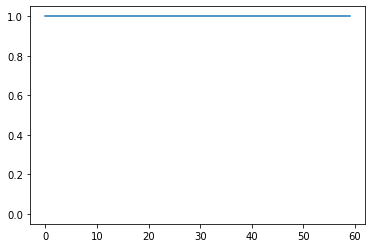

In [22]:
plt.plot((m).sum(1))
plt.plot([0],[0])